In [17]:
import warnings
warnings.filterwarnings('ignore')
import torch
dtype = torch.float
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
from torch.distributions import normal
import matplotlib.pyplot as plt, numpy as np, pickle
from scipy.stats import norm
from tifffile import imread
import sys
sys.path.append('../')
#from pn2v import *
from lib.gaussianMixtureNoiseModel import GaussianMixtureNoiseModel
from lib import histNoiseModel
from lib.utils import plotProbabilityDistribution
import os
import urllib
import zipfile
from pathlib import Path
import math
from pystackreg import StackReg
from skimage.transform import warp,AffineTransform

In [18]:
def crop_center(img,crop_size):

    if type(crop_size) == tuple:
        crop_x,crop_y = crop_size
    elif type(crop_size) == int:
        crop_x = crop_size
        crop_y = crop_size
    
    y,x = img.shape[-2::]
    startx = x//2-(crop_x//2)
    starty = y//2-(crop_y//2)        

    return img[...,starty:starty+crop_y,startx:startx+crop_x]

In [35]:
# Data paths
data_path = Path(r"E:\dl_monalisa\Data\Actin_fixed_mltplSNR_30nm_2\dump")
crop_size = (1392,1392)

# Choose parameters
noise_level = "all" # "all",list of int, or int
clean = "avg" 
display = True # display images and histograms or not
hist_bins = 512
clip = -3 # False or clip value
registration = False

# Saving dir parameters
if isinstance(noise_level,list):
    noise_level_str = ''.join(str(noise_level).split(', '))[1:-1]
else:
    noise_level_str = noise_level
noiseModelsDir = r"E:\dl_monalisa\Data\Actin_fixed_mltplSNR_30nm_2\noise_models"
nameHistNoiseModel = f"Hist_Noise{noise_level_str}_Sig{clean.upper()}_Clip{clip}"
nameGMMNoiseModel = f"GMM_Noise{noise_level_str}_Sig{clean.upper()}_Clip{clip}"

print(f"Noise level: {noise_level}")
print(f"Clean: {clean}")

print(f"Saving at: {noiseModelsDir}")
print(f"Histogram based noise model saving name: {nameHistNoiseModel}")
print(f"GMM based noise model saving name: {nameGMMNoiseModel}")

signal = []
observation = []
filters = ['tif','tiff']

files = os.listdir(data_path)

for f in files:
    if f.split('.')[-1] not in filters:
        print(f"removing {f} in signals because not in filters")
        files.remove(f)

for f in files:
    if f.split('.')[-1] not in filters:
        print(f"Removing {f} in observations because not in filters")
        files.remove(f)

print(f"\nFound {len(files)} files.\n")

if isinstance(noise_level,list) or noise_level == "all":
    mltplNoise = True
else:
    mltplNoise = False

for f in files:
    
    if clean == "avg":
        im_signal = np.mean(imread(data_path / f)[0:5],axis=0)
    else:
        raise ValueError("avg gt is the only one available for now for actin")
    
    # noise level selection
    if noise_level == "all":
        im_obs  = imread(data_path / f)
    elif isinstance(noise_level,int) or isinstance(noise_level,list):
        try:
            im_obs = imread(data_path / f)[noise_level]
        except IndexError:
            print(f"Image {f} ignored because of IndexError") 
            continue

    if not isinstance(clip,bool):
        im_obs[im_obs<clip] = 0
        im_signal[im_signal<clip] = 0

    if registration:
        if mltplNoise:
            print("Registration not available for multiple noise level")
        else:
            tf = StackReg.TRANSLATION
            sr = StackReg(tf)
            tmat = sr.register(ref=im_signal,mov=im_obs)
            tform = AffineTransform(matrix=tmat)
            im_obs = warp(im_obs, tform,order=0)

    im_obs = crop_center(im_obs,crop_size)
    im_signal = crop_center(im_signal,crop_size)
    
    observation.append(im_obs)
    signal.append(im_signal)

    print(f"File {f}: shape: {im_obs.shape}")


Noise level: all
Clean: avg
Saving at: E:\dl_monalisa\Data\Actin_fixed_mltplSNR_30nm_2\noise_models
Histogram based noise model saving name: Hist_Noiseall_SigAVG_Clip-3
GMM based noise model saving name: GMM_Noiseall_SigAVG_Clip-3
removing info.txt in signals because not in filters
removing Thumbs.db in signals because not in filters
Removing selected_data in observations because not in filters

Found 39 files.



TiffPage 0: TypeError: read_bytes() missing 3 required positional arguments: 'dtype', 'count', and 'offsetsize'


File 19h11m23s_rec_scan00_CAM.hdf5_multi.0.reconstruction.tiff: shape: (10, 1392, 1392)


TiffPage 0: TypeError: read_bytes() missing 3 required positional arguments: 'dtype', 'count', and 'offsetsize'


File 19h23m55s_rec_scan00_CAM.hdf5_multi.0.reconstruction.tif: shape: (9, 1392, 1392)
File 19h23m55s_rec_scan00_CAM.hdf5_multi.0.reconstruction.tiff: shape: (15, 1392, 1392)
File 19h33m23s_rec_scan00_CAM.hdf5_multi.0.reconstruction.tiff: shape: (13, 1392, 1392)
File 19h35m50s_rec_scan00_CAM.hdf5_multi.0.reconstruction.tiff: shape: (15, 1392, 1392)
File 19h38m18s_rec_scan00_CAM.hdf5_multi.0.reconstruction.tiff: shape: (15, 1392, 1392)
File 19h40m51s_rec_scan00_CAM.hdf5_multi.0.reconstruction.tiff: shape: (14, 1392, 1392)
File 19h43m53s_rec_scan00_CAM.hdf5_multi.0.reconstruction.tiff: shape: (15, 1392, 1392)
File 19h47m50s_rec_scan00_CAM.hdf5_multi.0.reconstruction.tiff: shape: (14, 1392, 1392)
File 19h50m30s_rec_scan00_CAM.hdf5_multi.0.reconstruction.tiff: shape: (15, 1392, 1392)
File 19h52m20s_rec_scan00_CAM.hdf5_multi.0.reconstruction.tiff: shape: (15, 1392, 1392)
File 19h55m06s_rec_scan00_CAM.hdf5_multi.0.reconstruction.tiff: shape: (15, 1392, 1392)
File 19h58m02s_rec_scan00_CAM.hdf5

In [37]:
full_signal = []
full_obs = []
for i,obs in enumerate(observation):
    sig = signal[i]
    sig = (sig - np.mean(sig))/np.std(sig)
    for frame in obs:
        norm_sig = sig * np.std(frame) + np.mean(frame)
        full_signal.append(norm_sig)
        full_obs.append(frame)


In [38]:
full_obs = np.stack(full_obs)
full_signal = np.stack(full_signal)

# # reshape im mltpl noise case
# if mltplNoise:
#     nNoise = observation.shape[1]
#     observation = np.reshape(observation,(observation.shape[0]*observation.shape[1],observation.shape[2],observation.shape[3]))    
#     signal = np.repeat(signal,nNoise,axis=0)

# # signal = (signal - np.mean(signal))/np.std(signal)
# # if mltplNoise:
# #     for noise in range(nNoise):
# #         observation[noise::nNoise] = (observation[noise::nNoise] - np.mean(observation[noise::nNoise]))/np.std(observation[noise::nNoise])
# # else:
# #     observation = (observation - np.mean(observation))/np.std(observation)


# # Normalize the signal range to the observation range
# if mltplNoise:
#     signal = (signal - np.mean(signal))/np.std(signal)
#     for noise in range(nNoise):
#         signal[noise::nNoise] = signal[noise::nNoise] * np.std(observation[noise::nNoise]) + np.mean(observation[noise::nNoise])
# else:
#     signal = (signal - np.mean(signal))/np.std(signal)
#     signal = signal * np.std(observation) + np.mean(observation)

signalnorm = (full_signal - np.mean(full_obs)) / np.std(full_obs)
observationnorm = (full_obs - np.mean(full_obs)) / np.std(full_obs)

minVal = np.min(full_signal)
maxVal = np.max(full_obs)

minValnorm = np.min(signalnorm)
maxValnorm = np.max(signalnorm)

print(f"\n\nConcatenated arrays:\tSignal: {full_signal.shape}\tObservation: {full_obs.shape}")




Concatenated arrays:	Signal: (535, 1392, 1392)	Observation: (535, 1392, 1392)


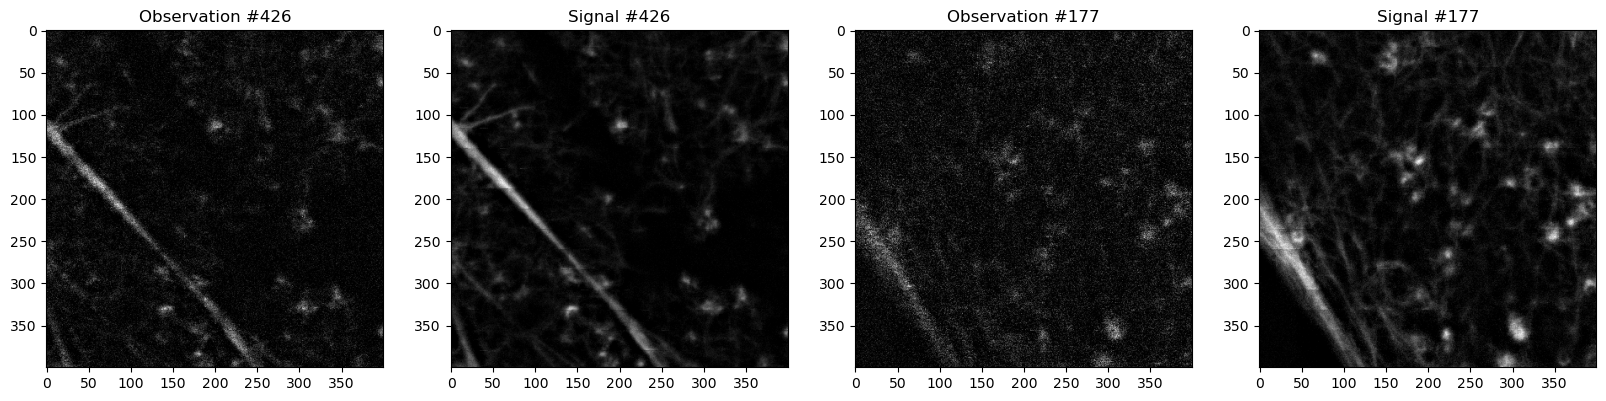

In [39]:
# Display examples of signals and observations if display is set to True

crop_size = 400
h,w = signal[0].shape

starty,startx = h//2-crop_size//2, w//2-crop_size//2
stopy,stopx = h//2+crop_size//2,w//2+crop_size//2

if display:
    idxs = np.random.randint(0,full_signal.shape[0],2)
    plt.figure(figsize=(20,10))
    for i in range(len(idxs)):
        sig = full_signal[idxs[i],starty:stopy,starty:stopy]
        obs = full_obs[idxs[i],starty:stopy,starty:stopy]
        plt.subplot(1,4,2*i+1)
        plt.imshow(obs,cmap="gray")
        plt.title(f"Observation #{idxs[i]}")
        plt.subplot(1,4,2*i+2)
        plt.imshow(sig,cmap="gray")
        plt.title(f"Signal #{idxs[i]}")

Hist noise model saved at E:\dl_monalisa\Data\Actin_fixed_mltplSNR_30nm_2\noise_models\Hist_Noiseall_SigAVG_Clip-3


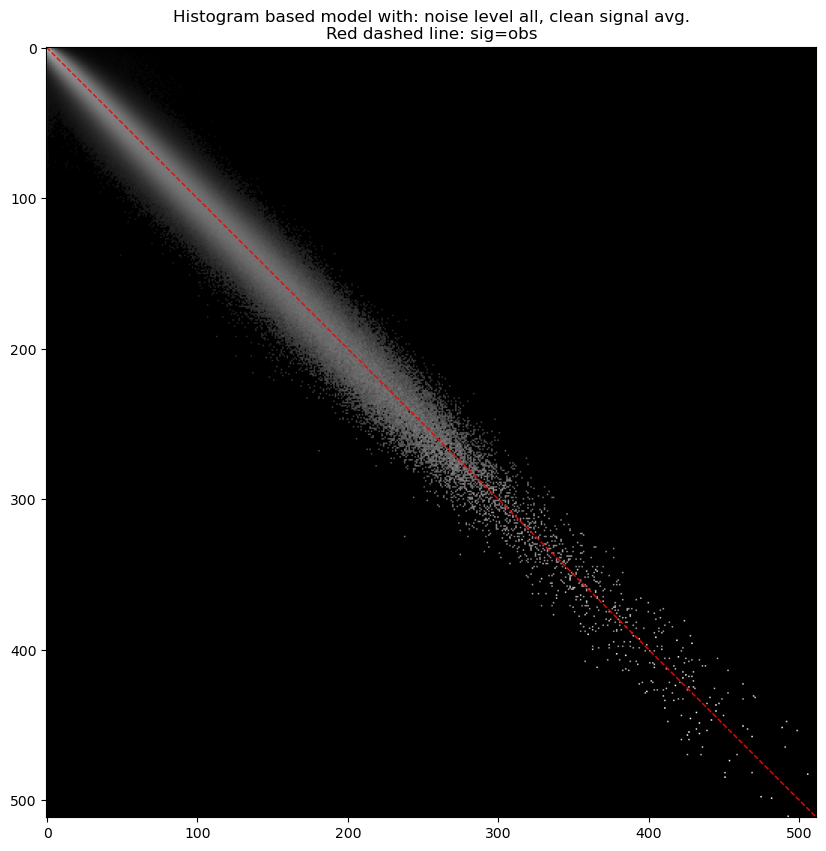

In [54]:
# Create, save and display histogram-based model

plt.figure(figsize=(10,10))
histogram = histNoiseModel.createHistogram(hist_bins, minValnorm, maxValnorm, observationnorm,signalnorm)

# Saving histogram
save_path = os.path.join(noiseModelsDir, nameHistNoiseModel)
np.save(save_path, histogram)
print(f"Hist noise model saved at {save_path}")

# Optional display
if display:
    plt.title(f"Histogram based model with: noise level {noise_level}, clean signal {clean}.\nRed dashed line: sig=obs")
    plt.imshow(histogram[0]**0.25, cmap='gray')
    plt.axline(xy1=(0,0),slope=1,color="red",linestyle="--",linewidth=1)
    plt.show()


In [55]:
# Training GMM noise model
n_gaussian = 5# Number of gaussians to use for Gaussian Mixture Model
n_coeff = 6# No. of polynomial coefficients for parameterizing the mean, standard deviation and weight of Gaussian components.
fullnameGMMNoiseModel = f"/{nameGMMNoiseModel}_nGauss{n_gaussian}_nCoeff{n_coeff}"

gaussianMixtureNoiseModel = GaussianMixtureNoiseModel(min_signal = minValnorm,
                                                    max_signal = maxValnorm,
                                                    path=str(noiseModelsDir), weight = None, 
                                                    n_gaussian = n_gaussian,
                                                    n_coeff = n_coeff,
                                                    min_sigma = 1, 
                                                    device = device)

gaussianMixtureNoiseModel.train(signalnorm, observationnorm, batchSize = 250000, n_epochs =1000, learning_rate=0.05, name = fullnameGMMNoiseModel,lowerClip=0)

Starting with loss = 1.3200395107269287
0 1.3200395107269287
Epoch 1: saved with loss 1.2731167078018188
Epoch 2: saved with loss 1.2315163612365723
Epoch 3: saved with loss 1.19533371925354
Epoch 4: saved with loss 1.1656806468963623
Epoch 5: saved with loss 1.1394174098968506
Epoch 6: saved with loss 1.1174240112304688
Epoch 7: saved with loss 1.097959280014038
Epoch 8: saved with loss 1.0821255445480347
Epoch 9: saved with loss 1.0680842399597168
Epoch 10: saved with loss 1.056693196296692
Epoch 11: saved with loss 1.0459794998168945
Epoch 12: saved with loss 1.037032127380371
Epoch 13: saved with loss 1.0292165279388428
Epoch 14: saved with loss 1.022639274597168
Epoch 15: saved with loss 1.0174226760864258
Epoch 16: saved with loss 1.0114943981170654
Epoch 17: saved with loss 1.0070574283599854
Epoch 18: saved with loss 1.0029205083847046
Epoch 19: saved with loss 0.9998287558555603
Epoch 20: saved with loss 0.9969103932380676
Epoch 21: saved with loss 0.9938708543777466
Epoch 22:

GMM_Noiseall_SigAVG_Clip-3_nGauss5_nCoeff6.npz


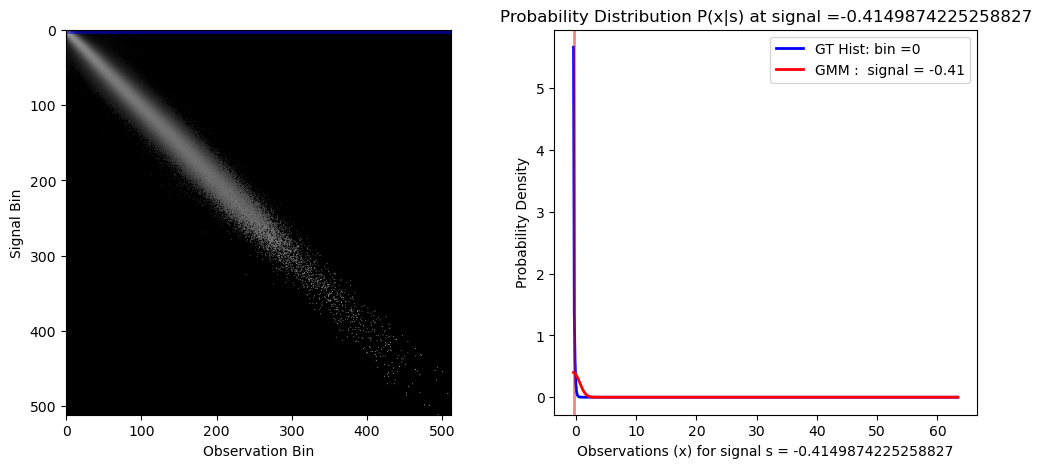

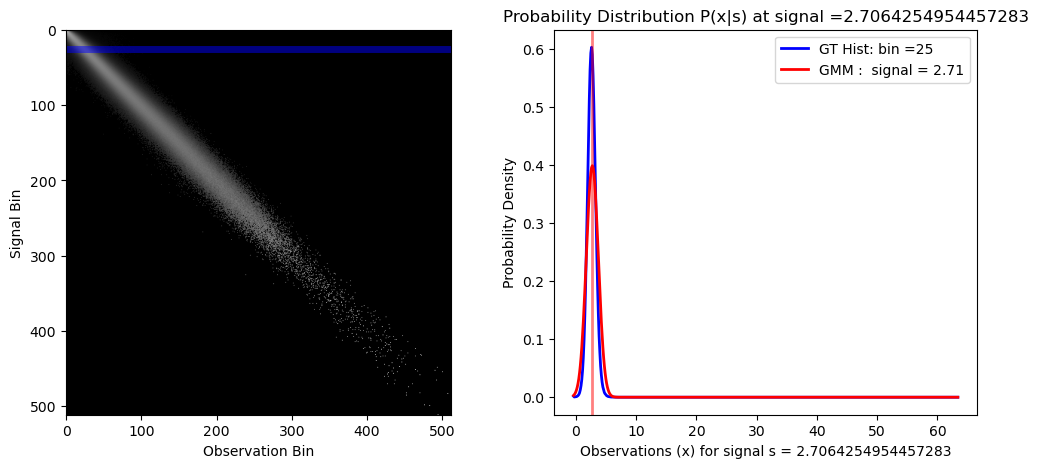

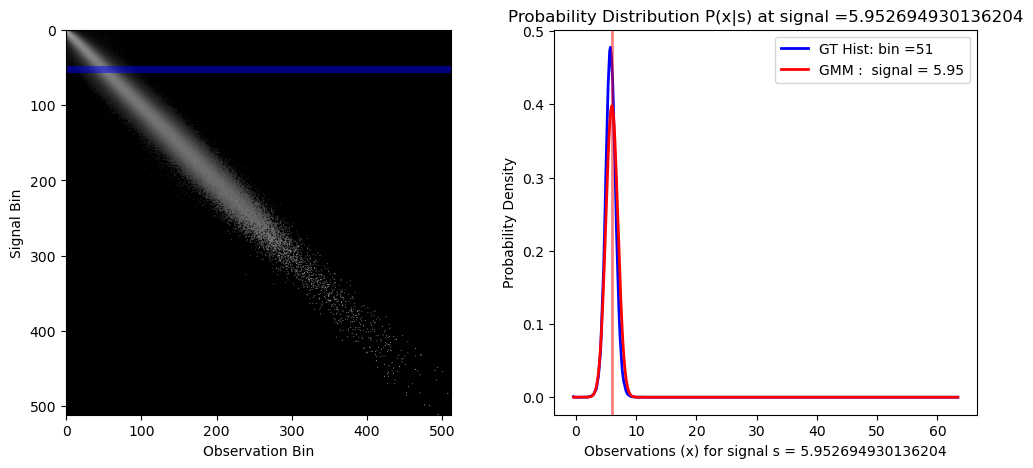

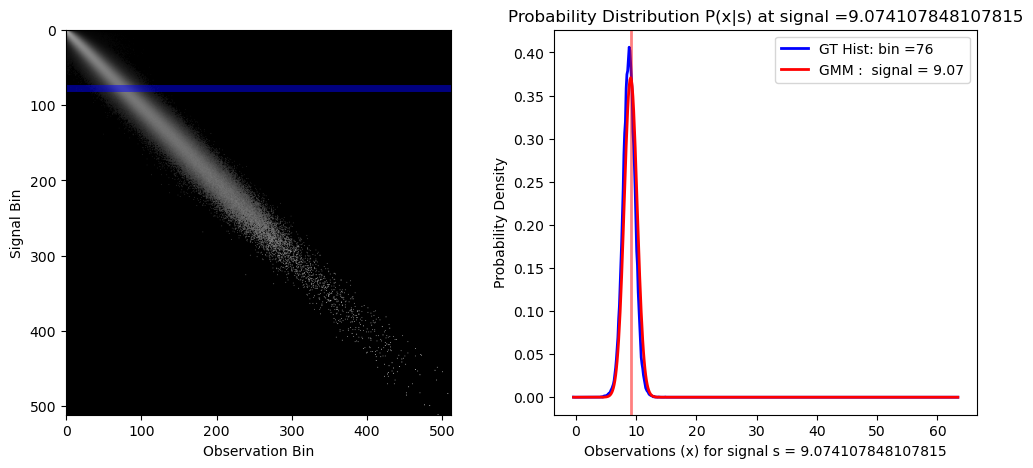

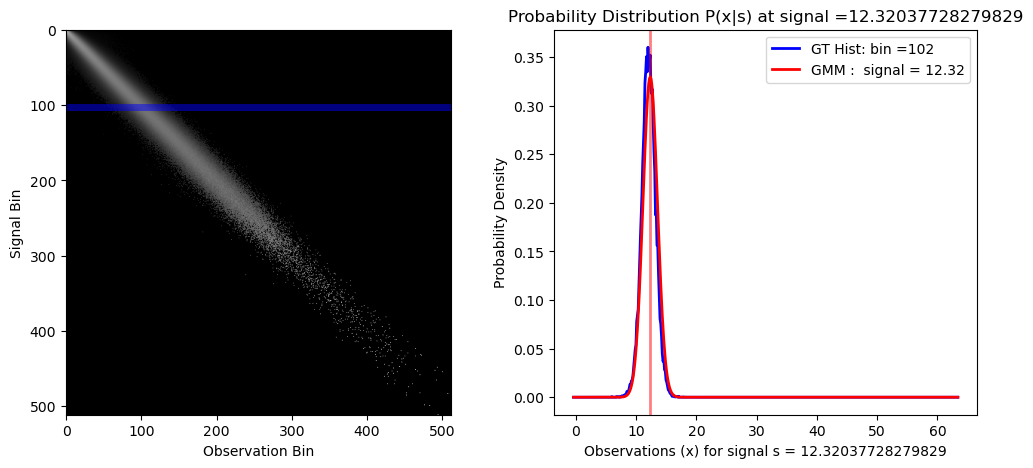

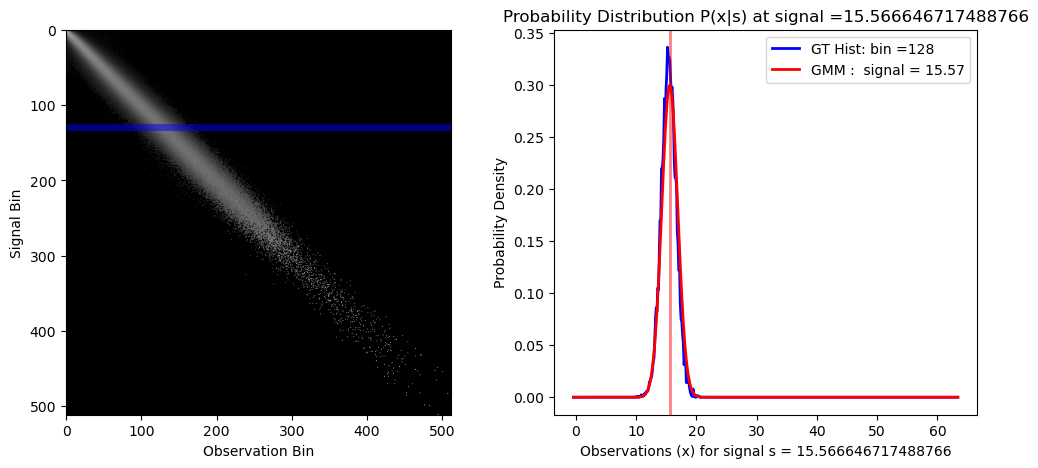

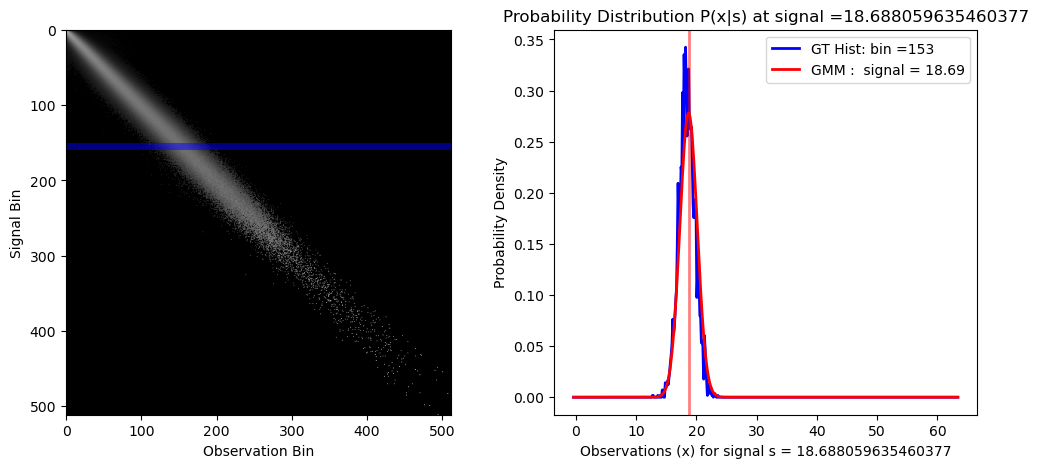

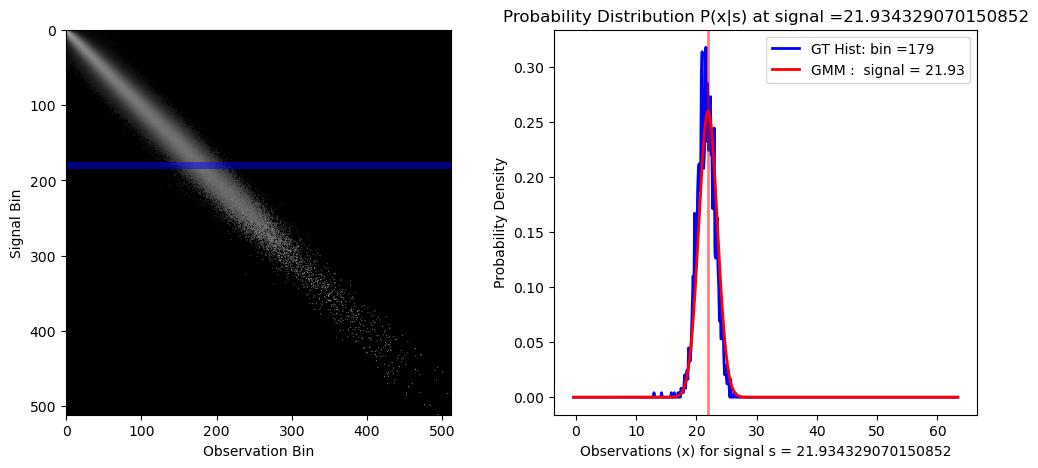

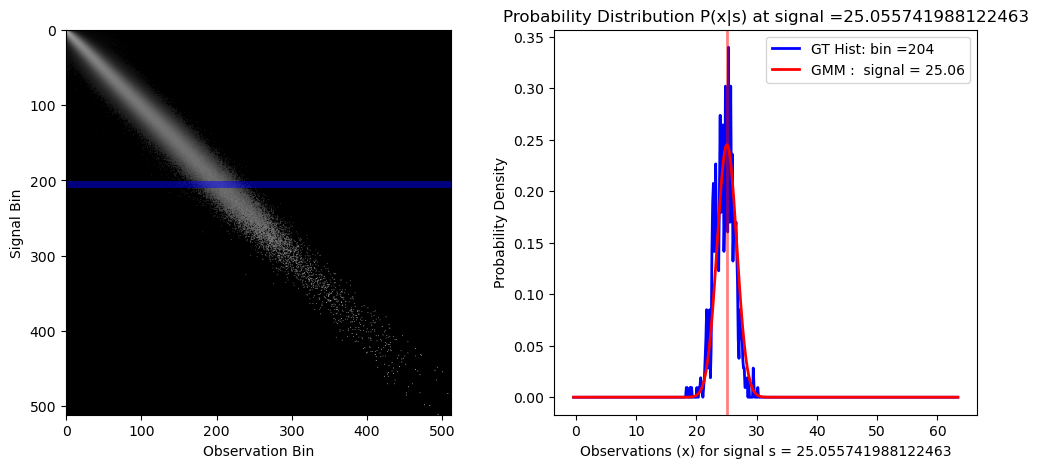

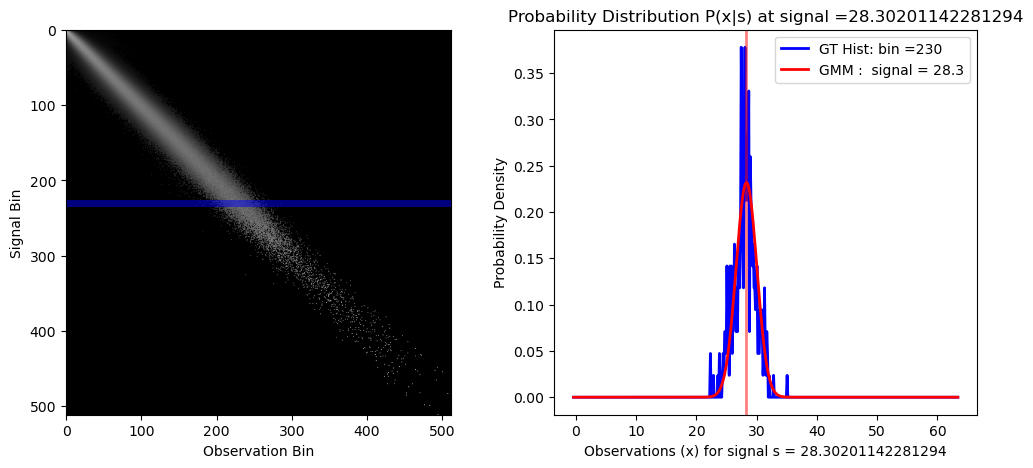

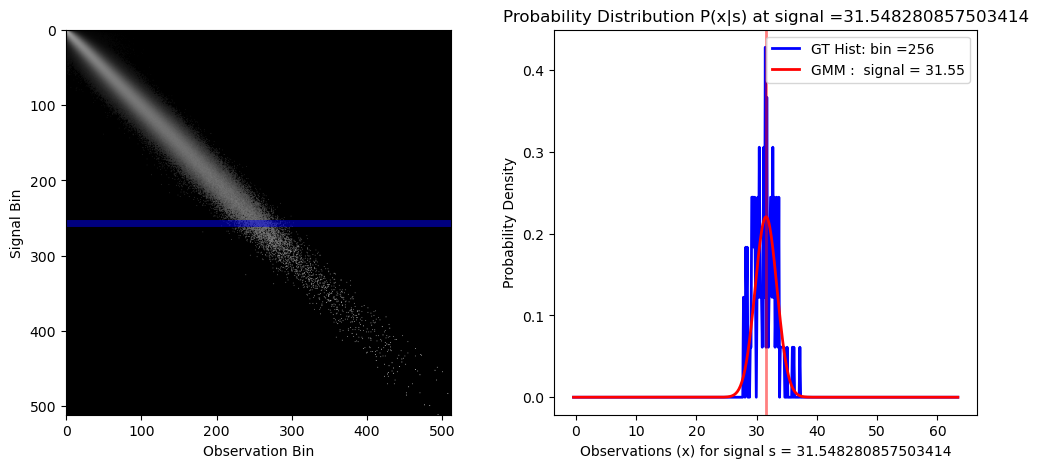

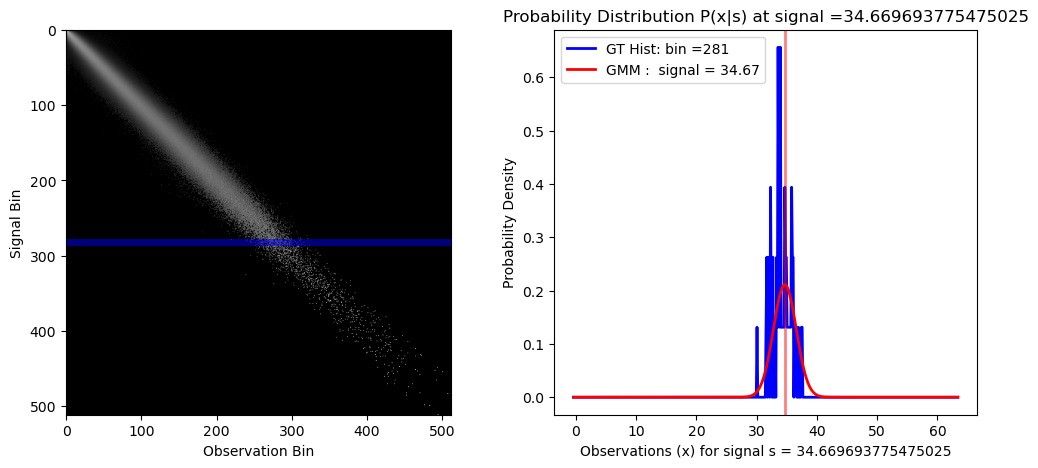

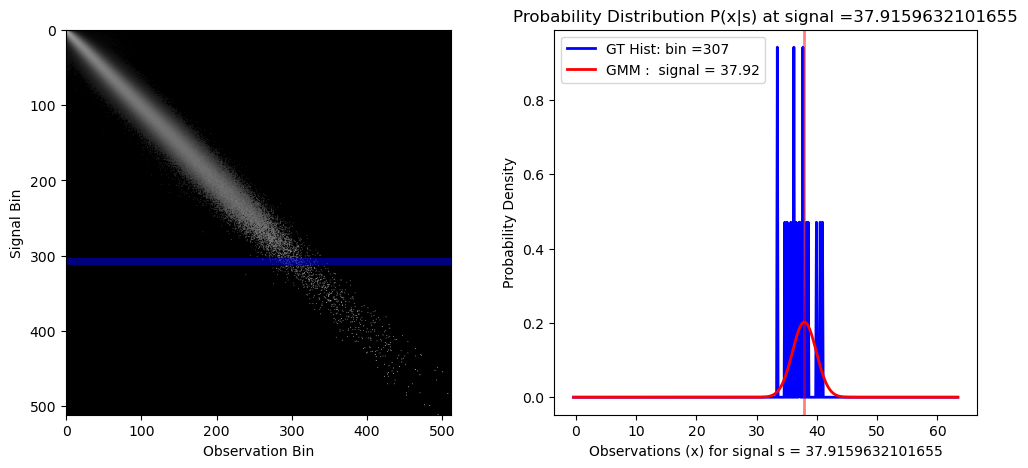

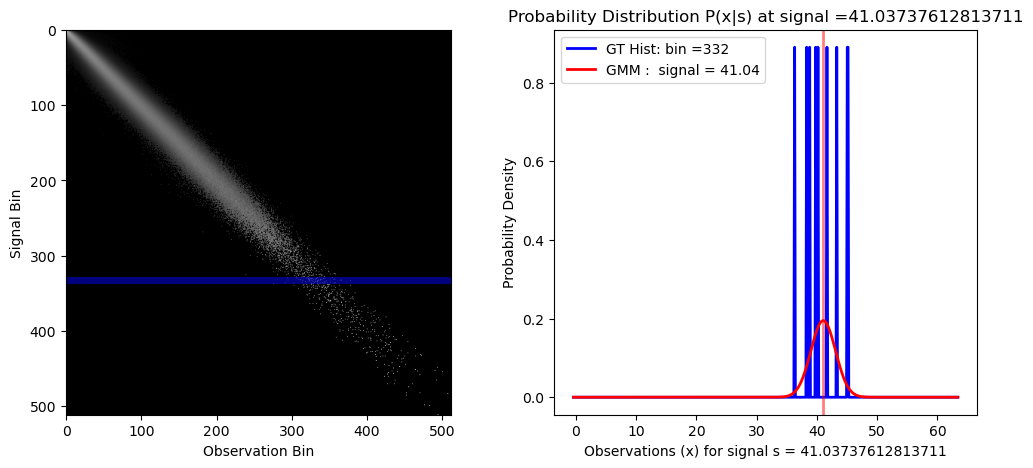

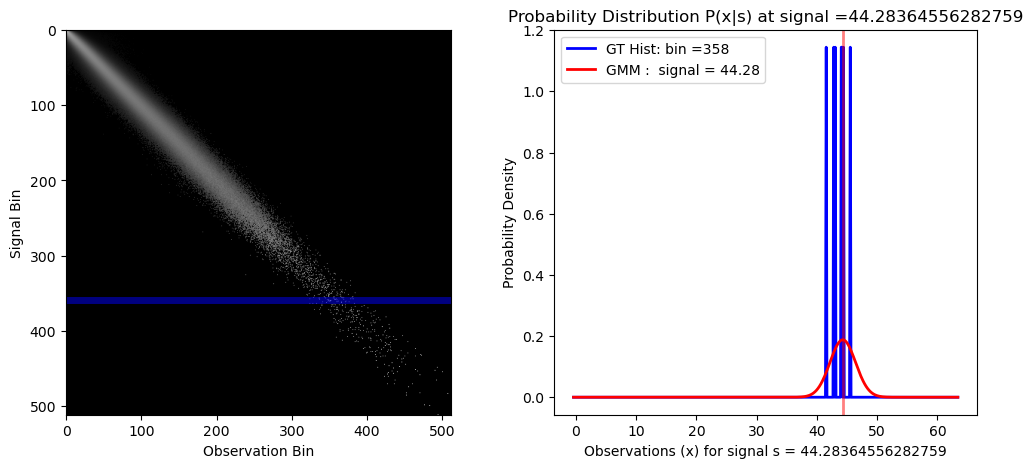

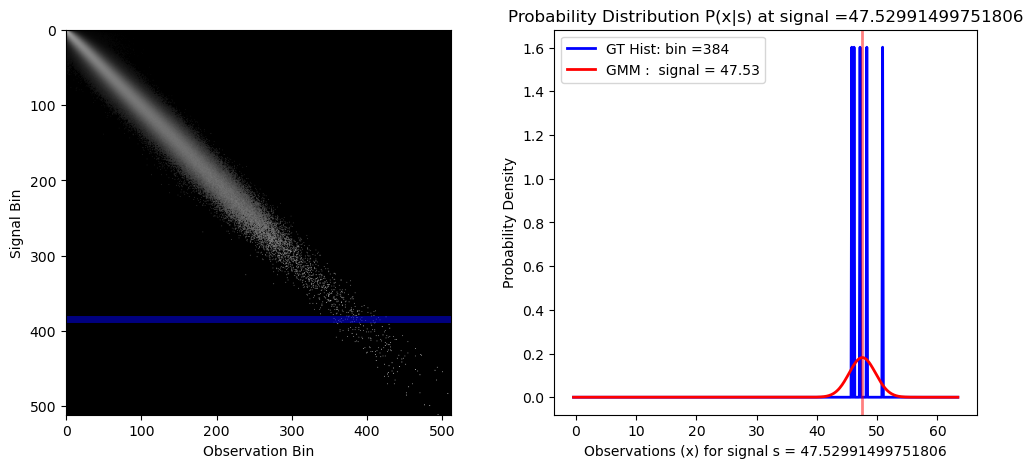

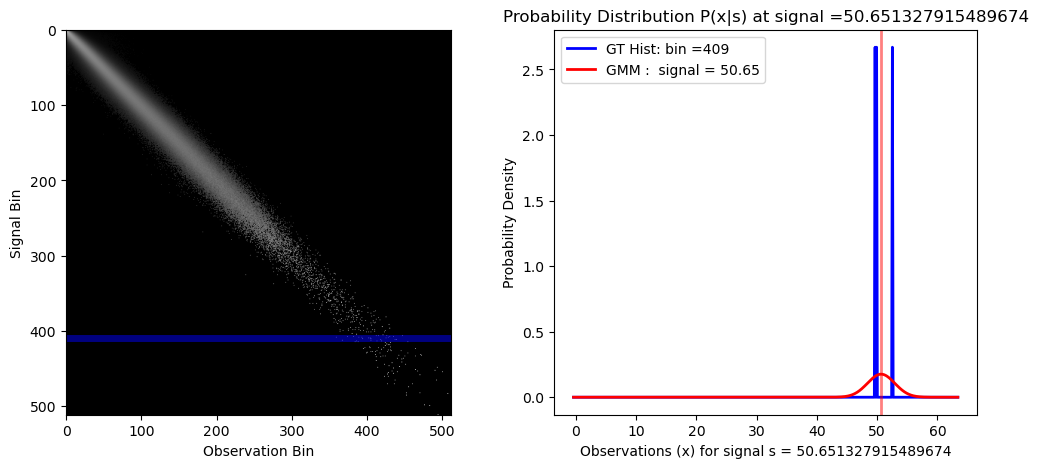

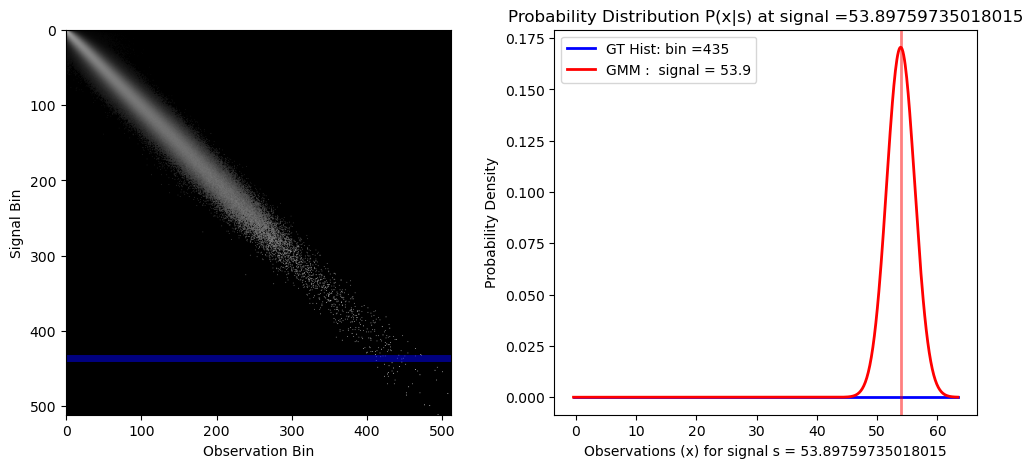

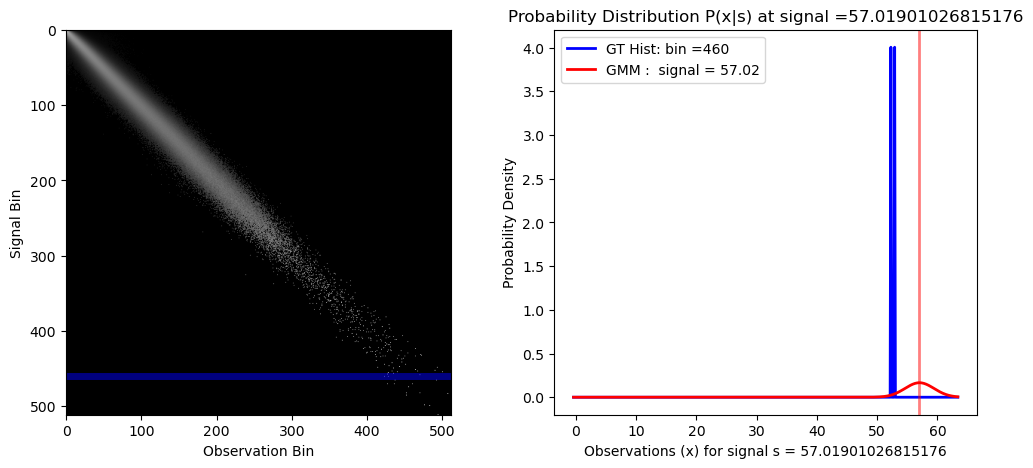

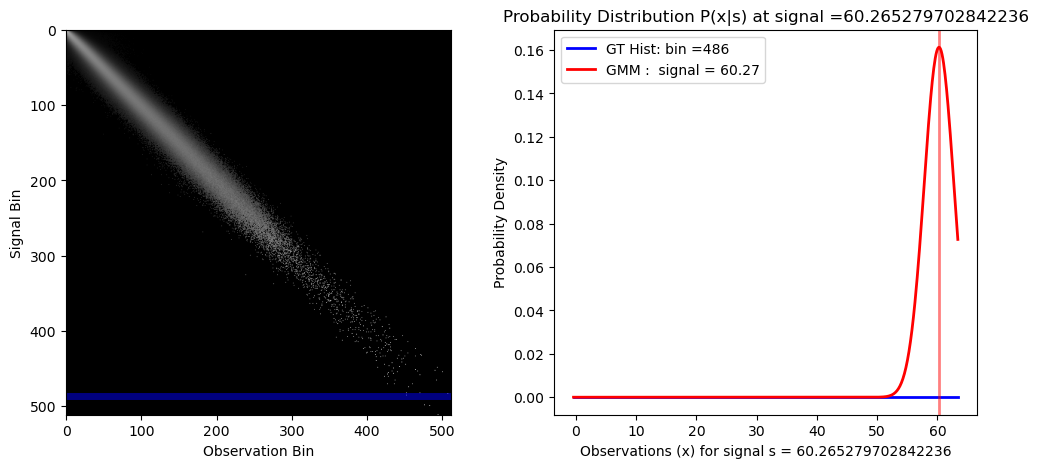

In [57]:
# Check GMM perf
GMMname = fullnameGMMNoiseModel[1::]+".npz" # to check current one
print(GMMname)
# GMMname = r"final_noReg/GMM_Noise0_SigN2V_Clip-3.npz"# to check existing one

n_points = 20
signalBinIndex_list = (np.linspace(0,n_points-1,n_points)*hist_bins//n_points).astype(int)
GMMmodel_prm = np.load(os.path.join(noiseModelsDir,GMMname))
GMMmodel = GaussianMixtureNoiseModel(params = GMMmodel_prm, device = device) 
# GMMmodel = gaussianMixtureNoiseModel
# GMMmodel.weight = torch.tensor([[ 1.8706, 0],
#         [-0.4762,  2.5608],
#         [ 0.9983, -1.9992]], device='cuda:0', requires_grad=True)


for binidx in signalBinIndex_list:
    plotProbabilityDistribution(signalBinIndex=binidx, histogram=histogram[0], gaussianMixtureNoiseModel=GMMmodel, min_signal=minValnorm, max_signal=maxValnorm, n_bin=hist_bins, device=device)